<a href="https://colab.research.google.com/github/withoutsultang/Cat-and-Dog-CNN/blob/main/machineLearning_catvsdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**머신러닝 기말고사 프로젝트** [데이터셋](https://www.kaggle.com/datasets/tongpython/cat-and-dog)

# 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 로드

In [2]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [3]:
class CatandDog(Dataset):
  def __init__(self, root, transform=None):
    self.root = root
    self.transform = transform
    self.images = []

    for i in ['cats', 'dogs']:
      path = os.path.join(root, i)
      for image in os.listdir(path):
        if image != '_DS_Store':
          self.images.append(os.path.join(path,image))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, i):
    image_path = os.path.join(self.root, self.images[i])
    image = Image.open(image_path).convert('RGB')
    if('dog' in self.images[i].lower()):
      label = 1
    else:
      label = 0

    if self.transform:
      image = self.transform(image)

    return image, label


In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))
])

In [5]:
root = '/content/drive/MyDrive/Colab Notebooks/content/archive'

In [6]:
train_path = root + '/training_set/training_set'
test_path = root + '/test_set/test_set'

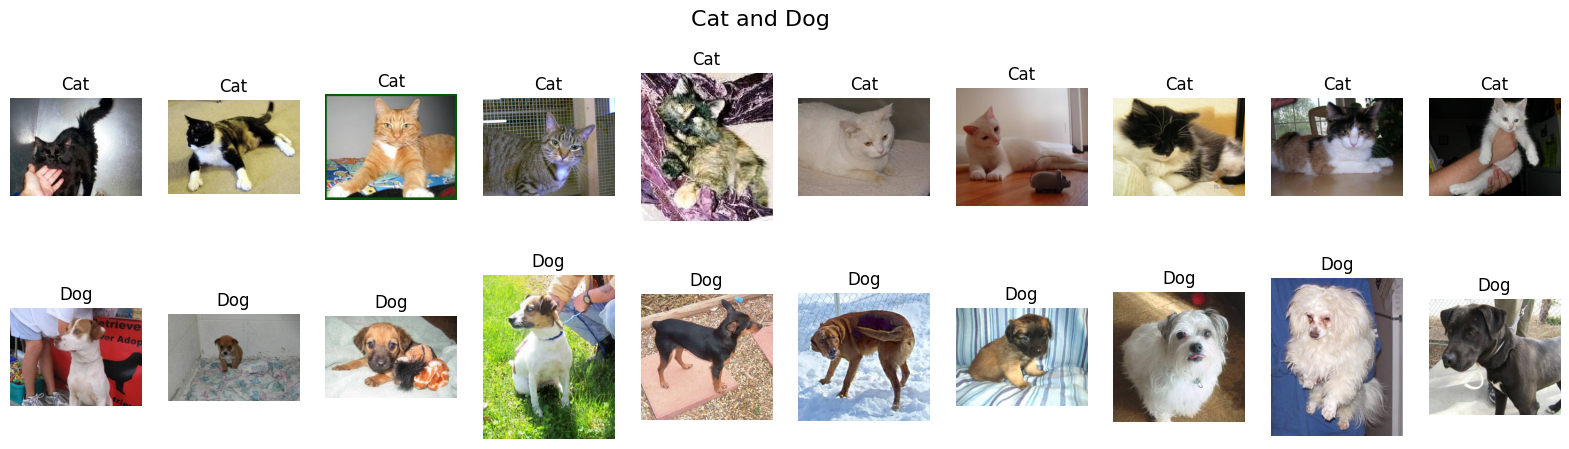

In [8]:
# 고양이와 강아지 이미지 경로를 각각 10장씩 저장할 리스트
cat_images = []
dog_images = []

# 고양이와 강아지 폴더 경로 설정
cats_path = os.path.join(train_path, 'cats')
dogs_path = os.path.join(train_path, 'dogs')

# 고양이 이미지 경로 수집
for image in os.listdir(cats_path):
    if image.lower().endswith(('.jpg', '.jpeg', '.png')) and len(cat_images) < 10:
        cat_images.append(os.path.join(cats_path, image))

# 강아지 이미지 경로 수집
for image in os.listdir(dogs_path):
    if image.lower().endswith(('.jpg', '.jpeg', '.png')) and len(dog_images) < 10:
        dog_images.append(os.path.join(dogs_path, image))

# 고양이와 강아지 이미지를 시각화
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
fig.suptitle('Cat and Dog', fontsize=16)

# 고양이 이미지 출력
for i, img_path in enumerate(cat_images):
    img = Image.open(img_path).convert('RGB')
    ax = axes[0, i]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Cat')

# 강아지 이미지 출력
for i, img_path in enumerate(dog_images):
    img = Image.open(img_path).convert('RGB')
    ax = axes[1, i]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Dog')

plt.show()


In [9]:
train = CatandDog(train_path, transform=transform)
test = CatandDog(test_path, transform=transform)

In [17]:
reduced_size = int(0.2 * len(train))
_, reduced_dataset = torch.utils.data.random_split(train, [len(train)-reduced_size, reduced_size])

In [18]:
loader = DataLoader(train, batch_size=32, shuffle=True)

In [11]:
class ConvolutionBlock(nn.Module):
  def __init__(self, input, output):
    self.intput = input
    self.output = output

    super().__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(input, output, (3,3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(output),
        nn.Conv2d(output, output, (3,3), stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(output),
    )

  def forward(self, x):
    y = self.layers(x)
    return y

In [12]:
class ConvolutionClassifier(nn.Module):
  def __init__(self, output):
    self.output = output

    super().__init__()

    self.blocks = nn.Sequential(
        ConvolutionBlock(3, 32),
        ConvolutionBlock(32, 64),
        ConvolutionBlock(64, 128),
        ConvolutionBlock(128, 256),
        ConvolutionBlock(256, 512),
    )

    self.layers = nn.Sequential(
        nn.Linear(512 * 4 * 4, 50),
        nn.ReLU(),
        nn.BatchNorm1d(50),
        nn.Linear(50, output),
        nn.LogSoftmax(dim=-1),
    )

  def forward(self, x):
    assert x.dim() == 4
    z = self.blocks(x)
    y = self.layers(z.view(z.size(0), -1))
    return y


In [14]:
class Trainer():
  def __init__(self, model, optimizer, crit):
    self.model = model
    self.optimizer = optimizer
    self.crit = crit

    super().__init__()

  def train(self, train_loader, valid_loader, config):
    best_loss = np.inf
    best_model = None

    for i in range(config.n_epochs):
      train_loss, train_acc = self._train(train_loader, config)
      valid_loss, valid_acc = self._validate(valid_loader, config)

      if valid_loss <= best_loss:
        best_loss = valid_loss
        best_model = deepcopy(self.model.state_dict())

      print("Epoch(%d/%d): train_loss=%.4f valid_loss=%.4f best_loss=%.4f train_acc=%.2f valid_acc=%.2f" %(
          i + 1,
          config.n_epochs,
          train_loss,
          valid_loss,
          best_loss,
          train_acc * 100,
          valid_acc * 100,
      ))

    self.model.load_state_dict(best_model)

  def _train(self, loader, config):
    self.model.train()
    total_loss = 0
    corr = 0
    total = 0

    for x, y in loader:
      x, y = x.to(config.device), y.to(config.device)
      y_hat = self.model(x)
      loss = self.crit(y_hat, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      total_loss += loss.item()

      _, predicted = torch.max(y_hat, 1)
      corr += (predicted == y).sum().item()
      total += y.size(0)

      avg_loss = total_loss / len(loader)
      accuracy = corr / total

    return avg_loss, accuracy

  def _validate(self, loader, config):
    self.model.eval()
    total_loss = 0
    corr = 0
    total = 0

    with torch.no_grad():
      for x,y in loader:
        x, y = x.to(config.device), y.to(config.device)
        y_hat = self.model(x)
        loss = self.crit(y_hat, y)
        total_loss += loss.item()

        _, predicted = torch.max(y_hat, 1)
        corr = (predicted == y).sum().item()
        total = y.size(0)

      avg_loss = total_loss / len(loader)
      accuracy = corr / total

    return avg_loss, accuracy

In [15]:
def define_arg():
  p = argparse.ArgumentParser()

  p.add_argument("--model_fn", required=False, default="/content/model.pth")
  p.add_argument("--gpu_id", type=int, default=0 if torch.cuda.is_available() else -1)
  p.add_argument("--batch_size", type=int, default=32)
  p.add_argument("--n_epochs", type=int, default=10)
  p.add_argument("--model", default="cnn", choices=["fc", "cnn"])
  p.add_argument("--verbose", type=int, default=1)

  config = p.parse_args(args=[])
  config.device = torch.device("cuda:%d" % config.gpu_id if config.gpu_id >= 0 else "cpu")


  return config

In [19]:
def main(config):

  dataset = CatandDog(root=train_path, transform=transform)
  train_size = int(len(dataset) * 0.8)
  valid_size=  len(dataset) - train_size
  train_data, valid_data = torch.utils.data.random_split(dataset, [train_size, valid_size] )

  train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
  valid_loader = DataLoader(valid_data, batch_size=config.batch_size, shuffle=True)

  output = 2 # dog and cat
  model = ConvolutionClassifier(output=output).to(config.device)
  optimizer = optim.Adam(model.parameters())
  crit = nn.NLLLoss()

  trainer = Trainer(model, optimizer, crit)
  trainer.train(train_loader, valid_loader, config)

  torch.save({
      "model": trainer.model.state_dict(),
      "optimizer": trainer.optimizer.state_dict(),
      "config": config,
  }, config.model_fn)


if __name__ == "__main__":
  config = define_arg()
  main(config)

Epoch(1/10): train_loss=0.6381 valid_loss=0.7486 best_loss=0.7486 train_acc=64.00 valid_acc=61.54
Epoch(2/10): train_loss=0.5770 valid_loss=0.6243 best_loss=0.6243 train_acc=70.16 valid_acc=53.85
Epoch(3/10): train_loss=0.5393 valid_loss=0.5522 best_loss=0.5522 train_acc=72.63 valid_acc=53.85
Epoch(4/10): train_loss=0.5054 valid_loss=0.5257 best_loss=0.5257 train_acc=75.20 valid_acc=100.00
Epoch(5/10): train_loss=0.4777 valid_loss=0.5344 best_loss=0.5257 train_acc=76.95 valid_acc=69.23
Epoch(6/10): train_loss=0.4322 valid_loss=0.5236 best_loss=0.5236 train_acc=79.90 valid_acc=84.62
Epoch(7/10): train_loss=0.3925 valid_loss=0.4835 best_loss=0.4835 train_acc=82.38 valid_acc=76.92
Epoch(8/10): train_loss=0.3537 valid_loss=0.4410 best_loss=0.4410 train_acc=84.86 valid_acc=76.92
Epoch(9/10): train_loss=0.3128 valid_loss=0.4549 best_loss=0.4410 train_acc=86.48 valid_acc=76.92
Epoch(10/10): train_loss=0.2632 valid_loss=0.4543 best_loss=0.4410 train_acc=89.06 valid_acc=61.54
